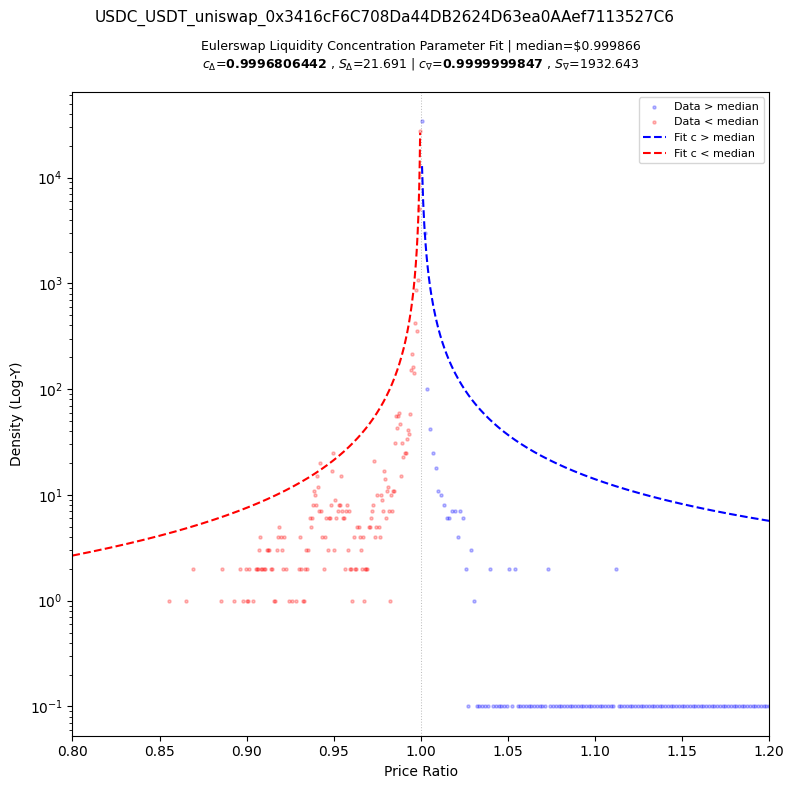

Optimal c above median: 0.9996806442, S_Δ: 21.691
Optimal c below median: 0.9999999847, S_∇: 1932.643


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares

"""
Eulerswap Parameters c_1 and c_2 with its corresponding scale S_1 and S_2 are fit.
One can use historical data as we have from previous stablecoin pools.
Alternatively one can make a forecast and feed the price forecast as a histogram as well.
We elect to use the median for stablecoins due to statistically significant alpha tails a<2 (see results of Eulerswap_tail_fit.py).
For other pools with a>2 the mean can be selected as the piecewise split for the trading functions.

Stablecoin pools:
    USDC_DAI_uniswap_0x5777d92f208679DB4b9778590Fa3CAB3aC9e2168
    USDT_DAI_uniswap_0x48da0965ab2d2cbf1c17c09cfb5cbe67ad5b1406
    USDC_USDT_uniswap_0x3416cF6C708Da44DB2624D63ea0AAef7113527C6   
"""

title='USDC_USDT_uniswap_0x3416cF6C708Da44DB2624D63ea0AAef7113527C6'
df_pool = pd.read_csv('data_euler/'+title+'.csv') #link to the folder containing the pool data
df_pool['evt_block_time'] = pd.to_datetime(df_pool['evt_block_time'], utc=True)
df = df_pool
column_select='price'
df['Price'] = pd.to_numeric(df[column_select], errors='coerce')
df['Returns'] = df[column_select].pct_change(1)  # Daily percentage change
df['Date'] = df_pool['evt_block_time']

# Filtered data
peak = df['Price'].median()
filtered_prices_above = df['Price'][df['Price'] > peak].dropna()
filtered_prices_below = df['Price'][df['Price'] < peak].dropna()

# Histograms for above median
bins_above = 500
counts_above, bin_edges_above = np.histogram(filtered_prices_above, bins=bins_above, density=False)
bin_centers_above = (bin_edges_above[:-1] + bin_edges_above[1:]) / 2
x_data_above, y_data_above = bin_centers_above, counts_above

# Histograms for below median
bins_below = bins_above
counts_below, bin_edges_below = np.histogram(filtered_prices_below, bins=bins_below, density=False)
bin_centers_below = (bin_edges_below[:-1] + bin_edges_below[1:]) / 2

# Filter out bins with zero counts and very small x values to avoid numerical issues
mask_below = (counts_below > 0) & (bin_centers_below > 0.01) 
x_data_below = bin_centers_below[mask_below]
y_data_below = counts_below[mask_below]

# Define functions
def f_above(x, c, S):
    return (x**1.5 * S * np.sqrt(1 - c)) / (x - c)**1.5

def f_below(x, c, S):
    return (x**(-1.5) * S * np.sqrt(1 - c)) / ((1/x) - c)**1.5

# Fit for above median
upper_c_above = min(1, np.min(x_data_above)) - 1e-6
bounds_above = ([-np.inf, 1e-6], [upper_c_above, np.inf])
p0_above = [0.5, 1.0]  # Initial guess for c and S
try:
    popt_above, _ = curve_fit(f_above, x_data_above, y_data_above, p0=p0_above, 
                             bounds=bounds_above, maxfev=10000)
    c_opt_above, S_opt_above = popt_above
except RuntimeError:
    # If curve_fit fails, try least_squares as a fallback
    def residual_above(params, x, y):
        c, S = params
        return y - f_above(x, c, S)
    result = least_squares(residual_above, p0_above, args=(x_data_above, y_data_above), 
                          bounds=bounds_above, method='trf')
    if result.success:
        c_opt_above, S_opt_above = result.x
    else:
        print("Optimization for above median did not succeed:", result.message)
        raise

# Fit for below median
p0_below = [0.5, 1.0]  # Initial guess
bounds_below = ([-10, 1e-6], [1, 1e6])  # Tighter bounds
try:
    popt_below, _ = curve_fit(f_below, x_data_below, y_data_below, p0=p0_below, 
                             bounds=bounds_below, maxfev=10000)
    c_opt_below, S_opt_below = popt_below
except RuntimeError:
    # If curve_fit fails, try least_squares as a fallback
    def residual_below(params, x, y):
        c, S = params
        return y - f_below(x, c, S)
    result = least_squares(residual_below, p0_below, args=(x_data_below, y_data_below), 
                          bounds=bounds_below, method='trf')
    if result.success:
        c_opt_below, S_opt_below = result.x
    else:
        print("Optimization for below median did not succeed:", result.message)
        raise

# Generate fitted curves
x_fit_above = np.linspace(np.min(x_data_above), np.max(x_data_above), 1200)
y_fit_above = f_above(x_fit_above, c_opt_above, S_opt_above)
x_fit_below = np.linspace(np.min(x_data_below), np.max(x_data_below), 1200)
y_fit_below = f_below(x_fit_below, c_opt_below, S_opt_below)

# Plot
plt.figure(figsize=(8, 8))
y_data_plot_above = np.where(y_data_above == 0, 0.1, y_data_above)
y_data_plot_below = np.where(y_data_below == 0, 0.1, y_data_below)
plt.scatter(x_data_above, y_data_plot_above, color='blue', label='Data > median', s=5, alpha=0.25)
plt.scatter(x_data_below, y_data_plot_below, color='red', label='Data < median', s=5, alpha=0.25)
plt.axvline(1, linestyle='dotted', lw=0.75, alpha=0.25, color='black')
plt.plot(x_fit_above, y_fit_above, color='blue', linestyle='--', label='Fit c > median')
plt.plot(x_fit_below, y_fit_below, color='red', linestyle='--', label='Fit c < median')
plt.xlabel('Price Ratio')
plt.ylabel('Density (Log-Y)')
plt.suptitle(title, fontsize=11)
plt.title(
    f'Eulerswap Liquidity Concentration Parameter Fit | median=${round(peak, 6)}\n' +
    f'$c_{chr(916)}$=$\\bf{{{c_opt_above:.10f}}}$ , $S_{chr(916)}$={S_opt_above:.3f} | ' +
    f'$c_{chr(8711)}$=$\\bf{{{c_opt_below:.10f}}}$ , $S_{chr(8711)}$={S_opt_below:.3f}\n',
    size=9
)
plt.legend(fontsize=8)
plt.tight_layout()
plt.yscale('log')
plt.xlim(0.8, 1.2)
plt.show()

print(f"Optimal c above median: {c_opt_above:.10f}, S_Δ: {S_opt_above:.3f}")
print(f"Optimal c below median: {c_opt_below:.10f}, S_∇: {S_opt_below:.3f}")